In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


pd.set_option('display.max_columns', 50)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# NÚMERO DE TRANSAÇÕES
N = 20000

#TAXA DE FRAUDE DESEJADA (CLASSE DESBALANCEADA)
TARGET_FRAUD_RATE = 0.03
# Em antifraude, fraude é rara (1% a 5% é comum em muitas bases)

# Gerar variáveis (features) com sentido de negócio

In [4]:
# 1) Hora da transação: 0 a 23 (inteiro)
transaction_hour = np.random.randint(0, 24, size=N)

# 2) Idade da conta em dias: contas novas tendem a ser mais arriscadas em alguns cenários
# Simular idades entre 1 e 2000 dias, mas com mais contas "mais novas" (distribuição exponencial)
account_age_days = np.clip(np.random.exponential(scale=300, size=N), 1, 2000).astype(int)

# 3) Quantidade de transações nas últimas 24h: pode indicar comportamento anormal
# Usar uma Poisson (contagem), com média maior para contas mais antigas (mais uso normal)
base_lambda = 2 + (account_age_days / 400)  # contas mais antigas tendem a ter mais transações "normais"
transactions_last_24h = np.random.poisson(lam=base_lambda).astype(int)

# 4) Transação internacional (0/1): raro, mas relevante
is_foreign_transaction = np.random.binomial(n=1, p=0.08, size=N)  # ~8% internacionais

# 5) País de alto risco (0/1): ainda mais raro
is_high_risk_country = np.random.binomial(n=1, p=0.03, size=N)    # ~3%

# 6) Ticket médio últimos 7 dias: valores em reais (simulação)
# Simular que usuários têm um padrão de gasto "pessoal"
avg_amount_last_7d = np.clip(np.random.lognormal(mean=3.6, sigma=0.6, size=N), 10, 5000)

# 7) Valor da transação (transaction_amount)
# Em antifraude, valores muito acima do ticket médio podem indicar risco.
# Simular o valor como "ticket médio * um fator aleatório"
spike_factor = np.random.lognormal(mean=0.0, sigma=0.7, size=N)  # às vezes o usuário faz compras maiores
transaction_amount = np.clip(avg_amount_last_7d * spike_factor, 1, 20000)


# Score de risco

In [6]:
# Criar um "risco" baseado em sinais comuns:
# - conta muito nova
# - transação internacional
# - país de alto risco
# - horário incomum (madrugada)
# - valor muito acima do ticket médio
# - volume muito alto de transações nas últimas 24h

# Feature auxiliar: "valor relativo" ao ticket médio
amount_ratio = transaction_amount / (avg_amount_last_7d + 1e-6)  # +1e-6 evita divisão por zero

# Feature auxiliar: horário de risco (ex: 0-5h)
late_night = ((transaction_hour >= 0) & (transaction_hour <= 5)).astype(int)

# Score linear (quanto maior, maior risco)
# Esses pesos são "arbitrados" (simulação), mas com lógica de negócio.
risk_score = (
    1.2 * is_foreign_transaction +
    2.0 * is_high_risk_country +
    0.8 * late_night +
    1.0 * (amount_ratio > 2.5).astype(int) +
    0.6 * (transactions_last_24h > 10).astype(int) +
    1.3 * (account_age_days < 30).astype(int)
)

# Adicionar um ruído pequeno para não ficar "determinístico"
risk_score = risk_score + np.random.normal(loc=0, scale=0.3, size=N)


# Converter score em probabilidade e calibrar para ~3% de fraude

In [8]:
def sigmoid(x):
    """Função logística: transforma qualquer número em probabilidade (0 a 1)."""
    return 1 / (1 + np.exp(-x))

# Achar um "intercepto" (bias) que faça a taxa média ficar próxima do TARGET_FRAUD_RATE
# Estratégia simples: testar vários valores e escolher o melhor
candidate_biases = np.linspace(-8, 0, 200)  # faixa típica de bias (negativo para deixar fraude rara)
best_bias = None
best_diff = 1e9

for b in candidate_biases:
    p = sigmoid(risk_score + b)
    diff = abs(p.mean() - TARGET_FRAUD_RATE)
    if diff < best_diff:
        best_diff = diff
        best_bias = b

# Probabilidade final
fraud_proba = sigmoid(risk_score + best_bias)

# Gerar o alvo (fraud) com base nessas probabilidades (0/1)
fraud = np.random.binomial(n=1, p=fraud_proba, size=N)

best_bias, fraud.mean()


(-4.4623115577889445, 0.0313)

In [9]:
df = pd.DataFrame({
    "transaction_amount": transaction_amount,
    "transaction_hour": transaction_hour,
    "is_foreign_transaction": is_foreign_transaction,
    "is_high_risk_country": is_high_risk_country,
    "account_age_days": account_age_days,
    "transactions_last_24h": transactions_last_24h,
    "avg_amount_last_7d": avg_amount_last_7d,
    "amount_ratio": amount_ratio,   # feature auxiliar (pode virar parte do modelo)
    "late_night": late_night,       # feature auxiliar
    "fraud": fraud
})

# Visualizar amostra
df.head()


,transaction_amount,transaction_hour,is_foreign_transaction,is_high_risk_country,account_age_days,transactions_last_24h,avg_amount_last_7d,amount_ratio,late_night,fraud
0,40.401981,6,0,0,110,0,63.583005,0.635421,0,0
1,28.413878,19,0,0,341,3,34.407407,0.825807,0,0
2,55.945807,14,1,0,250,3,44.692719,1.251788,0,0
3,42.531654,10,1,0,171,2,86.232686,0.493220,0,0
4,70.186377,7,0,0,232,2,44.832504,1.565524,0,0


In [10]:
# Taxa de fraude
print("Fraud rate:", df["fraud"].mean())

# Estatísticas rápidas
display(df.describe())

# Checar como fraude se comporta em alguns sinais
print("\nFraud rate em transações internacionais:", df.loc[df["is_foreign_transaction"] == 1, "fraud"].mean())
print("Fraud rate em país alto risco:", df.loc[df["is_high_risk_country"] == 1, "fraud"].mean())
print("Fraud rate na madrugada:", df.loc[df["late_night"] == 1, "fraud"].mean())
print("Fraud rate em contas < 30 dias:", df.loc[df["account_age_days"] < 30, "fraud"].mean())
print("Fraud rate quando amount_ratio > 2.5:", df.loc[df["amount_ratio"] > 2.5, "fraud"].mean())


Fraud rate: 0.0313


,transaction_amount,transaction_hour,is_foreign_transaction,is_high_risk_country,account_age_days,transactions_last_24h,avg_amount_last_7d,amount_ratio,late_night,fraud
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,56.151266,11.644600,0.076700,0.034050,301.347100,2.753750,44.097651,1.276075,0.244500,0.031300
std,64.476862,6.925907,0.266121,0.181362,299.905254,1.809385,29.477688,1.025051,0.429801,0.174132
min,1.059483,0.000000,0.000000,0.000000,1.000000,0.000000,10.000000,0.070860,0.000000,0.000000
25%,19.874068,6.000000,0.000000,0.000000,87.000000,1.000000,24.380245,0.626232,0.000000,0.000000
50%,36.956068,12.000000,0.000000,0.000000,210.000000,3.000000,36.675748,0.999907,0.000000,0.000000
75%,68.182400,18.000000,0.000000,0.000000,415.000000,4.000000,54.732322,1.595445,0.000000,0.000000
max,1358.214724,23.000000,1.000000,1.000000,2000.000000,20.000000,394.609701,20.262966,1.000000,1.000000



Fraud rate em transações internacionais: 0.08344198174706649
Fraud rate em país alto risco: 0.1512481644640235
Fraud rate na madrugada: 0.052351738241308794
Fraud rate em contas < 30 dias: 0.07930672268907563
Fraud rate quando amount_ratio > 2.5: 0.0625328428796637


In [11]:
# Preparar dados para o modelo 

feature_cols = [
    "transaction_amount",
    "transaction_hour",
    "is_foreign_transaction",
    "is_high_risk_country",
    "account_age_days",
    "transactions_last_24h",
    "avg_amount_last_7d",
    "amount_ratio",
    "late_night"
]

X = df[feature_cols].copy()   # X = variáveis explicativas
y = df["fraud"].copy()        # y = alvo (0/1)

X.head(), y.value_counts(normalize=True)

(   transaction_amount  transaction_hour  is_foreign_transaction  \
 0           40.401981                 6                       0   
 1           28.413878                19                       0   
 2           55.945807                14                       1   
 3           42.531654                10                       1   
 4           70.186377                 7                       0   
 
    is_high_risk_country  account_age_days  transactions_last_24h  \
 0                     0               110                      0   
 1                     0               341                      3   
 2                     0               250                      3   
 3                     0               171                      2   
 4                     0               232                      2   
 
    avg_amount_last_7d  amount_ratio  late_night  
 0           63.583005      0.635421           0  
 1           34.407407      0.825807           0  
 2           44.69271

In [12]:
# 2) Separar treino e teste (com stratify)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,            # 30% teste
    random_state=RANDOM_SEED,  # reprodutível
    stratify=y                 # mantém proporção de fraude igual em treino e teste
)

y_train.mean(), y_test.mean()

(0.031285714285714285, 0.03133333333333333)

In [13]:
# 3) Treinar modelo baseline (LogReg)

model = LogisticRegression(
    max_iter=1000,       # garante convergência
    class_weight="balanced",  # ajuda em desbalanceamento
    random_state=RANDOM_SEED
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [14]:
# 4) Predições e probabilidade (scores)

# Probabilidade de ser fraude (classe 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Predição padrão do sklearn usa threshold=0.5
y_pred_default = (y_scores >= 0.5).astype(int)

y_scores[:5], y_pred_default[:20]

(array([0.57006085, 0.41265975, 0.5154739 , 0.31506666, 0.37302862]),
 array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]))

In [15]:
# 5) Avaliação: Precision, Recall, F1

precision = precision_score(y_test, y_pred_default, zero_division=0)
recall = recall_score(y_test, y_pred_default, zero_division=0)
f1 = f1_score(y_test, y_pred_default, zero_division=0)
cm = confusion_matrix(y_test, y_pred_default)

print("Threshold = 0.5 (padrão)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, zero_division=0))

Threshold = 0.5 (padrão)
Precision: 0.0613
Recall:    0.6064
F1 Score:  0.1114

Confusion Matrix:
[[4067 1745]
 [  74  114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      5812
           1       0.06      0.61      0.11       188

    accuracy                           0.70      6000
   macro avg       0.52      0.65      0.46      6000
weighted avg       0.95      0.70      0.80      6000



In [40]:
# 6) Calibrar threshold: F1 vs threshold

thresholds = np.linspace(0.05, 0.95, 19)

precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)

    p = precision_score(y_test, y_pred_t, zero_division=0)
    r = recall_score(y_test, y_pred_t, zero_division=0)
    f = f1_score(y_test, y_pred_t, zero_division=0)

    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f)

P_MIN = 0.15  # piso de precision (ajuste depois: 0.15, 0.20...)

# Criar uma tabelinha para enxergar e filtrar
results = pd.DataFrame({
    "threshold": thresholds,
    "precision": precisions,
    "recall": recalls,
    "f1": f1_scores
})

# (Opcional, mas MUITO útil) taxa de alertas: % de transações marcadas como fraude
# Isso traduz diretamente "volume operacional"
alert_rates = []
for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    alert_rates.append(y_pred_t.mean())

results["alert_rate"] = alert_rates

# Filtrar thresholds que atendem o piso mínimo de precision
candidates = results[results["precision"] >= P_MIN].copy()

print("Candidatos (precision >= P_MIN):", len(candidates))
display(candidates.sort_values(["recall", "precision"], ascending=False).head(10))

if candidates.empty:
    print("Nenhum threshold atingiu o piso de precision. Tente diminuir P_MIN (ex: 0.05) ou usar mais thresholds.")
else:
    chosen = candidates.sort_values(
        ["recall", "precision"], ascending=[False, False]
    ).iloc[0]

    chosen_threshold = float(chosen["threshold"])
    print("Threshold escolhido (Opção 1):", chosen_threshold)
    print(chosen)

best_idx = int(np.argmax(f1_scores))
best_t = float(thresholds[best_idx])

print("Melhor threshold (max F1):", best_t)
print("Precision:", precisions[best_idx])
print("Recall:   ", recalls[best_idx])
print("F1:       ", f1_scores[best_idx])

Candidatos (precision >= P_MIN): 4


,threshold,precision,recall,f1,alert_rate
15,0.80,0.181818,0.202128,0.191436,0.034833
16,0.85,0.227273,0.106383,0.144928,0.014667
17,0.90,0.195122,0.042553,0.069869,0.006833
18,0.95,0.333333,0.015957,0.030457,0.001500


Threshold escolhido (Opção 1): 0.7999999999999999
threshold     0.800000
precision     0.181818
recall        0.202128
f1            0.191436
alert_rate    0.034833
Name: 15, dtype: float64
Melhor threshold (max F1): 0.7
Precision: 0.14150943396226415
Recall:    0.3191489361702128
F1:        0.19607843137254902


In [42]:
# Avaliar métricas finais com o threshold escolhido
y_pred_chosen = (y_scores >= chosen_threshold).astype(int)

precision_chosen = precision_score(y_test, y_pred_chosen, zero_division=0)
recall_chosen = recall_score(y_test, y_pred_chosen, zero_division=0)
f1_chosen = f1_score(y_test, y_pred_chosen, zero_division=0)
cm_chosen = confusion_matrix(y_test, y_pred_chosen)

print(f"Threshold escolhido: {chosen_threshold}")
print(f"Precision: {precision_chosen:.4f}")
print(f"Recall:    {recall_chosen:.4f}")
print(f"F1 Score:  {f1_chosen:.4f}")
print("\nConfusion Matrix [[TN, FP],[FN, TP]]:")
print(cm_chosen)
print("\nAlert rate:", y_pred_chosen.mean())

Threshold escolhido: 0.7999999999999999
Precision: 0.1818
Recall:    0.2021
F1 Score:  0.1914

Confusion Matrix [[TN, FP],[FN, TP]]:
[[5641  171]
 [ 150   38]]

Alert rate: 0.034833333333333334


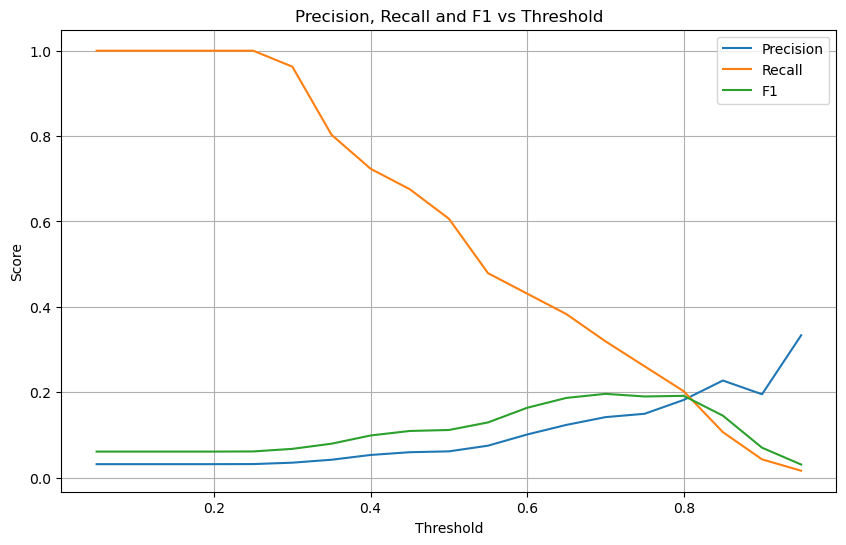

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
rows = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    
    # Métricas
    p = precision_score(y_test, y_pred_t, zero_division=0)
    r = recall_score(y_test, y_pred_t, zero_division=0)
    f = f1_score(y_test, y_pred_t, zero_division=0)
    
    # Matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    alert_rate = y_pred_t.mean()
    alerts = y_pred_t.sum()
    
    rows.append({
        "threshold": t,
        "precision": p,
        "recall": r,
        "f1": f,
        "alert_rate": alert_rate,
        "alerts": alerts,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

results_full = pd.DataFrame(rows)

results_full.sort_values("threshold")

,threshold,precision,recall,f1,alert_rate,alerts,TP,FP,FN,TN
0,0.05,0.031333,1.000000,0.060763,1.000000,6000,188,5812,0,0
1,0.10,0.031333,1.000000,0.060763,1.000000,6000,188,5812,0,0
2,0.15,0.031333,1.000000,0.060763,1.000000,6000,188,5812,0,0
3,0.20,0.031333,1.000000,0.060763,1.000000,6000,188,5812,0,0
4,0.25,0.031533,1.000000,0.061138,0.993667,5962,188,5774,0,38
5,0.30,0.034808,0.962766,0.067186,0.866667,5200,181,5019,7,793
6,0.35,0.041678,0.803191,0.079244,0.603833,3623,151,3472,37,2340
7,0.40,0.052877,0.723404,0.098551,0.428667,2572,136,2436,52,3376
8,0.45,0.059346,0.675532,0.109107,0.356667,2140,127,2013,61,3799
9,0.50,0.061323,0.606383,0.111383,0.309833,1859,114,1745,74,4067


In [ ]:
# Resumo comparativo para decisão (exemplo: 0.50, 0.55, 0.60, 0.80)
chosen_set = results_full[results_full["threshold"].isin([0.50, 0.55, 0.60, 0.80])].copy()
chosen_set["alerts_per_tp"] = chosen_set["alerts"] / chosen_set["TP"]
chosen_set.sort_values("threshold")

## Decision: threshold selection (business & operational view)

This notebook evaluates a fraud detection baseline on an imbalanced dataset and analyzes the **Precision–Recall trade-off** across multiple classification thresholds.

### Key idea
- Lower thresholds increase **Recall** (fewer missed frauds / fewer FN), but typically increase **False Positives (FP)** and operational load.
- Higher thresholds increase **Precision** (higher alert quality), but reduce **Recall** (more frauds missed).

### Operational metric
To translate model performance into operational impact, we also track:
- **alerts**: number of transactions flagged as fraud
- **alerts_per_tp**: number of alerts generated per captured fraud (TP)

### Chosen threshold (example)
A threshold of **0.60** provides a reasonable compromise:
- Precision ≈ **0.10**
- Recall ≈ **0.43**
- alerts_per_tp ≈ **9.9**

This choice reduces alert volume compared to a more aggressive threshold (e.g., 0.50) while maintaining meaningful fraud capture, which can better preserve the customer journey and investigation capacity.

> In a real production setup, the threshold decision should be guided by business costs (FN vs FP), operational capacity, and potentially customer segmentation (e.g., VIP vs mass-market).


In [48]:
# Summary table for decision discussion (operational view)
chosen_thresholds = [0.50, 0.55, 0.60, 0.70, 0.80]

summary = results_full[results_full["threshold"].isin(chosen_thresholds)].copy()
summary["alerts_per_tp"] = summary["alerts"] / summary["TP"]

summary.sort_values("threshold")

,threshold,precision,recall,f1,alert_rate,alerts,TP,FP,FN,TN,alerts_per_tp
11,0.6,0.100872,0.430851,0.163471,0.133833,803,81,722,107,5090,9.913580
13,0.7,0.141509,0.319149,0.196078,0.070667,424,60,364,128,5448,7.066667
